![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Caminhos dos arquivos
filename_features = "./UCI HAR Dataset/features.txt"
filename_labels = "./UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "./UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "./UCI HAR Dataset/train/y_train.txt"

filename_subtest = "./UCI HAR Dataset/test/subject_test.txt"
filename_xtest = "./UCI HAR Dataset/test/X_test.txt"
filename_ytest = "./UCI HAR Dataset/test/y_test.txt"

# Leitura dos arquivos de features e labels
features = pd.read_csv(filename_features, header=None, sep="\s+", names=['nome_var'])
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Função para adicionar sufixos aos nomes duplicados
def adicionar_sufixo_nomes_duplicados(nomes):
  nomes_unicos = []
  contador = {}
  for nome in nomes:
    if nome in contador:
      contador[nome] += 1
      nome_unico = f"{nome}_{contador[nome]}"
    else:
      contador[nome] = 0
      nome_unico = nome
    nomes_unicos.append(nome_unico)
  return nomes_unicos

# Gerando lista de nomes de colunas únicos
nomes_unicos = adicionar_sufixo_nomes_duplicados(features['nome_var'].tolist())

# Leitura dos arquivos de dados com os nomes de colunas únicos
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=nomes_unicos)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=nomes_unicos)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [7]:
%%time

clf = DecisionTreeClassifier(random_state=1234).fit(X_train, y_train)
caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0.001])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)


CPU times: total: 1min 49s
Wall time: 1min 49s


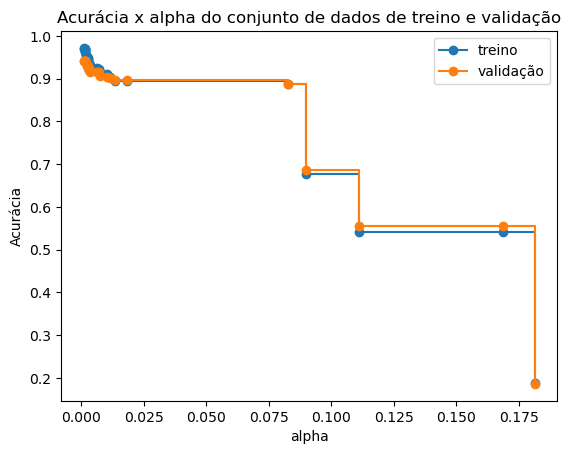

In [8]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="validação", drawstyle="steps-post")
ax.legend()
plt.show()

In [9]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

acc_train = train_scores[ind_melhor_arvore]
acc_valid = valid_scores[ind_melhor_arvore]
acc_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia da melhor árvore na base de treino:    {acc_train*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {acc_teste*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {acc_teste*100:.1f}')

Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 87.0
Acurácia da melhor árvore na base de teste:     87.0


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [10]:
%%time
prcomp = PCA().fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_valida = prcomp.transform(X_valid)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

CPU times: total: 1.84 s
Wall time: 392 ms


(5514, 561)

In [11]:
%%time
n=1

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,cp1
0,-5.673263
1,4.920175
2,-3.661583
3,6.041153
4,4.519566


In [12]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 2.64 s
Wall time: 2.66 s


In [13]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 94.2
Acurácia da melhor árvore na base de teste:     38.4


DecisionTreeClassifier(ccp_alpha=2.5908078138763523e-05, random_state=2360873)

## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


In [14]:
%%time
print("Número de componentes = 2")

n=2

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

lf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)
    
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Número de componentes = 2
Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 94.2
Acurácia da melhor árvore na base de teste:     50.5
CPU times: total: 3.31 s
Wall time: 3.39 s


DecisionTreeClassifier(ccp_alpha=2.4173569736238602e-05, random_state=2360873)

In [15]:
%%time
print("Número de componentes = 5")

n=5

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

lf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)
    
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Número de componentes = 5
Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 94.2
Acurácia da melhor árvore na base de teste:     74.7
CPU times: total: 3.78 s
Wall time: 3.81 s


DecisionTreeClassifier(ccp_alpha=1.2621884221449627e-05, random_state=2360873)

In [16]:
%%time
print("Número de componentes = 10")

n=10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

lf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)
    
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Número de componentes = 10
Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 94.2
Acurácia da melhor árvore na base de teste:     80.7
CPU times: total: 6.31 s
Wall time: 6.34 s


DecisionTreeClassifier(ccp_alpha=4.231652762664759e-05, random_state=2360873)

In [17]:
%%time
print("Número de componentes = 50")

n=50

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_valid = pd.DataFrame(pc_valida[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

lf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)
    
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

Número de componentes = 50
Acurácia da melhor árvore na base de treino:    96.5
Acurácia da melhor árvore na base de validação: 94.2
Acurácia da melhor árvore na base de teste:     79.8
CPU times: total: 31.7 s
Wall time: 31.8 s


DecisionTreeClassifier(ccp_alpha=1.4867969166118783e-05, random_state=2360873)

## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

A acurácia esteve mais alta conforme os componentes também foram aumentando e a mesma coisa aconteceu com o tempo de processamento.